<a href="https://colab.research.google.com/github/erfunmirzaei/Social_Bandit/blob/main/Social_Bandit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import csv
import json
import matplotlib.pyplot as plt
import random
import gym
from scipy.stats import t
from statistics import mean
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Implementations

## Rewards

In [ ]:
class MultinomialReward():
    def __init__(self, rewards, probs):
        self.rewards = rewards
        self.probs = probs
        self.mean = np.array(probs) @ np.array(rewards)        

    def get_reward(self, t):
        return random.choices(self.rewards, weights = self.probs, k = 1)[0]

In [ ]:
class DeteriministicReward():
    def __init__(self, reward):
        self.reward = reward
        self.mean = reward
        
    def get_reward(self, t):
        return self.reward

In [ ]:
class GaussianReward():
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def get_reward(self, t):
        return np.random.normal(loc=self.mean, scale=self.std)

In [ ]:
class Students_t_distReward():
    def __init__(self,dof, mean, std):
        self.dof = dof
        self.mean = mean
        self.std = std

    def get_reward(self, t):
        return t.rvs(df = self.dof, loc=self.mean, scale=self.std)

In [ ]:
class MultinomialReward_NonStationary():
    def __init__(self, rewards, probs, switch_t):
        self.rewards = rewards
        self.probs = probs
        self.mean = np.array(probs) @ np.array(rewards)  
        self.switch_t = switch_t

    def get_reward(self, t):
        if t < self.switch_t:
            return random.choices(self.rewards, weights = self.probs, k = 1)[0]
        
        else:
            return random.choices(self.rewards[::-1], weights = self.probs, k = 1)[0]

## N-Armed Bandit Environments

In [ ]:
class MutliArmedBanditEnvironment():
    def __init__(self, rewards, episode_max_length, id, container=None):
        state_space = gym.spaces.Discrete(1)
        action_space = gym.spaces.Discrete(len(rewards))

        self.action_space = action_space
        self.observation_space = state_space
        self.state = None
        self.id = id
        self.agents = {}
        
        if container != None:
            container.register_environment(self)
        self.arms_rewards = rewards # consits all rewards method
        self.episode_max_length = episode_max_length
        self.state = {
            'length': 0,
            'last_action': None
        }

    def add_agent(self, agent_id):
        self.agents_last_choice[agent_id] = -1 
        
    def calculate_reward(self, action):
        return self.arms_rewards[action].get_reward(self.state['length'])

    def terminated(self):
        return self.state['length'] >= self.episode_max_length

    def observe(self):
        return {}

    def n_actions(self):
        return self.action_space.n

    def next_state(self, action):
        self.state['length'] += 1
        self.state['last_action'] = action
    
    def get_info(self):
        return {} 

    def update_selected(self, action, agent_id):
        if agent_id == -1:
            return
        self.agents_last_choice[agent_id] = action

    def step(self, action, agent_id):
        reward = self.calculate_reward(action)
        observation = self.observe()
        info = self.get_info()
        self.next_state(action)
        done = self.terminated()
        self.update_selected(action, agent_id) #agent_id == -1 ==> do nothing
        return observation, reward, done, info

    def reset(self):
        self.state['length'] = 0
        self.state['last_action'] = None

    def render(self, mode='human'):
        print('{}:\taction={}'.format(self.state['length'], self.state['last_action']))

    def close(self):
        return

In [ ]:
class SocialMutliArmedBanditEnvironment():
    def __init__(self, rewards, episode_max_length, container = None):
        state_space = gym.spaces.Discrete(1)
        action_space = gym.spaces.Discrete(len(rewards))

        self.action_space = action_space
        self.observation_space = state_space
        
        if container != None:
            container.register_environment(self)

        self.arms_rewards = rewards
        self.agents_last_choice = {}
        self.episode_max_length = episode_max_length
        # self.optimal_action = np.argmax(R_mean)

        self.state = {
            'length': 0,
            'last_action': None
        }
    
    def add_agent(self, agent_id):
        self.agents_last_choice[agent_id] = -1 
     
    def calculate_reward(self, action):
        return self.arms_rewards[action].get_reward(self.state['length'])
    
    def update_selected(self, action, agent_id):
        if agent_id == -1:
            return
        self.agents_last_choice[agent_id] = action
        
    def step(self, action, agent_id):
        reward = self.calculate_reward(action)
        observation = self.observe()
        info = self.get_info()
        self.next_state(action)
        done = self.terminated()
        self.update_selected(action, agent_id) #agent_id == -1 ==> do nothing
        return observation, reward, done, info
    
    def terminated(self):
        return self.state['length'] >= self.episode_max_length

    def observe(self):
        return {}
    
    def n_actions(self):
        return self.action_space.n

    def next_state(self, action):
        self.state['length'] += 1
        self.state['last_action'] = action
    
    def get_info(self):
        return {} 

    def config(self):
        self.agents_last_choice = []
    
    def reset(self):
        self.state['length'] = 0
        self.state['last_action'] = None

    def render(self, mode='human'):
        print('{}:\taction={}'.format(self.state['length'], self.state['last_action']))

    def close(self):
        return

# Agents 

## Learner Agents

In [ ]:
from abc import ABC, abstractmethod

class AgentBase:
    def __init__(self, id, environment=None):
        self.id = id
        self.environment = environment
        self.environment.add_agent(id)

    def set_environment(self, env):
        self.environment = env

    @abstractmethod
    def take_action(self) -> (object, float, bool, object):
        # in this method, you MUST call the `step` method of 
        # the environment and observe the results and return them like:
        # return observation, reward, done, info
        pass
    
    def utility_function(self,reward):
        if reward >= 0 :
            u = reward ** self.alpha
        else:
            u =  -1 * self.gamma * ((-reward)** self.beta)
        return u 

In [ ]:
import numpy as np
#Add Temperature

class EpsilonGreedyAgent(AgentBase): 
    def __init__(self, id, environment, epsilon = 0.1,epsilon_decay = 1,lr = None,lr_decay = 1,alpha = 1,beta = 1,gamma = 1,optimistic = False):
        super(EpsilonGreedyAgent, self).__init__(id, environment)
        n_actions = self.environment.n_actions()
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.lr = lr
        self.lr_decay = lr_decay
        self.alpha = alpha
        self.beta = beta 
        self.gamma = gamma
        self.Q = np.zeros((n_actions,1))     #action value fuction
        self.N = np.zeros((n_actions,1))     #number of doing an action 

    def get_number_actions(self):
        return self.N

    def update(self,action,utility):
        self.epsilon = self.epsilon * self.epsilon_decay
        self.N[action] += 1
        if self.lr is not None:
            self.Q[action] += (utility - self.Q[action]) * self.lr
            self.lr = self.lr * self.lr_decay 
        else:
            self.Q[action] += (utility - self.Q[action])/self.N[action] 

    def select_action(self):
        n_actions = self.environment.n_actions()
        rand = np.random.rand()
        if rand < self.epsilon:
            action = np.random.choice(n_actions)
        else:
            action = np.argmax(self.Q)
        
        return action

    def take_action(self) -> (object, float, bool, object):
        action = self.select_action()
        obs, r, d, i = self.environment.step(action, self.id)
        u = self.utility_function(r)
        self.update(action,u)
        
        return r, action , u

    def get_Q(self):
        return self.Q

In [ ]:
import numpy as np

class UCBAgent(AgentBase):
    def __init__(self, id, environment, c, lr = None, lr_decay = 1,alpha = 1,beta = 1,gamma = 1):
        super(UCBAgent, self).__init__(id, environment)
        n_actions = self.environment.n_actions()
        self.c = c
        self.lr = lr
        self.lr_decay = lr_decay
        self.alpha = alpha
        self.beta = beta 
        self.gamma = gamma
        self.Q = np.zeros((n_actions,1))                 #action value function(expected reward) for each arm
        self.N = np.zeros((n_actions,1))                 #number of doing each arm
        self.trial = 0                                          #number of total trials 
        self.UCB = np.inf * np.ones((n_actions,1))      #Upper confidence bound for each arm
        
    def select_action(self):        
        action = np.random.choice(np.flatnonzero(self.UCB == self.UCB.max()))
        return action 

    def update(self, action, u):        
        # update action values
        self.trial += 1
        self.N[action] = self.N[action] + 1
        if self.lr is not None:
            self.Q[action] += self.lr*(u-self.Q[action])
            self.lr = self.lr * self.lr_decay
        else:
            self.Q[action] += (u-self.Q[action]) / self.N[action]

        self.UCB = self.Q + self.c * np.sqrt(np.log(self.trial)/(self.N + 1e-9))

        
    def take_action(self) -> (object, float, bool, object):
        action = self.select_action()
        obs, r, d, i = self.environment.step(action, self.id)
        u = self.utility_function(r)
        self.update(action, u)
        return r, action, u

In [ ]:
import numpy as np

class GradientBanditAgent(AgentBase): 
    def __init__(self, id, environment, lr = 0.1,lr_decay = 1,alpha = 1,beta = 1,gamma = 1,optimistic = False, Baseline_lr = None):
        super(GradientBanditAgent, self).__init__(id, environment)
        n_actions = self.environment.n_actions()
        self.lr = lr
        self.lr_decay = lr_decay
        self.R_lr = Baseline_lr
        self.alpha = alpha
        self.beta = beta 
        self.gamma = gamma
        self.avg_rew = 0   
        self.N = 0      
        self.H = np.zeros((n_actions))
        self.P = (1/n_actions)*np.ones((n_actions))

    def update(self,action,utility):
        self.lr = self.lr * self.lr_decay
        self.N += 1
        if self.R_lr is not None:
            self.avg_rew += (utility - self.avg_rew) * self.R_lr
        else:
            self.avg_rew += (utility - self.avg_rew)/self.N

        for i in range(len(self.H)):
            if i == action :
                self.H[i] += self.lr *(utility - self.avg_rew)*(1-self.P[i])

            else:
                self.H[i] -=  self.lr *(utility - self.avg_rew)*(self.P[i])

        for i in range(len(self.P)):
            self.P[i] = np.exp(self.H[i]) / np.sum(np.exp(self.H))

    def get_all(self):
        return self.H,self.P

    def select_action(self):
        n_actions = self.environment.n_actions()
        action = int(np.random.choice(list(range(n_actions)), size=1,p=self.P))       
        return action 

    def take_action(self) -> (object, float, bool, object):
        action = self.select_action()
        obs, r, d, i = self.environment.step(action, self.id)
        #print(obs, r, d, i)
        u = self.utility_function(r)
        self.update(action,u)
        #self.environment.render()
        return r, action , u


In [ ]:
import numpy as np

class ActorCriticAgent(AgentBase): 
    def __init__(self, id, environment, lr = 0.1,lr_decay = 1,alpha = 1,beta = 1,gamma = 1,optimistic = False):
        super(ActorCriticAgent, self).__init__(id, environment)
        n_actions = self.environment.n_actions()
        self.lr = lr
        self.lr_decay = lr_decay
        self.alpha = alpha
        self.beta = beta 
        self.gamma = gamma
        self.N = 0      
        self.Q = np.zeros((n_actions))     #action value fuction
        self.H = np.zeros((n_actions))
        self.P = (1/n_actions)*np.ones((n_actions))

    def update(self,action,utility):
        self.lr = self.lr * self.lr_decay
        self.N += 1
        if self.lr is not None:
            self.Q[action] += (utility - self.Q[action]) * self.lr
            self.lr = self.lr * self.lr_decay 
        else:
            self.Q[action] += (utility - self.Q[action])/self.N[action] 

        for i in range(len(self.H)):
            if i == action :
                self.H[i] += self.lr *(utility - self.Q[i])*(1-self.P[i])

            else:
                self.H[i] -=  self.lr *(utility - self.Q[i])*(self.P[i])

        for i in range(len(self.P)):
            self.P[i] = np.exp(self.H[i]) / np.sum(np.exp(self.H))

    def get_all(self):
        return self.H,self.P

    def select_action(self):
        n_actions = self.environment.n_actions()
        action = int(np.random.choice(list(range(n_actions)), size=1,p=self.P))  
        return action

    def take_action(self) -> (object, float, bool, object):
        action = self.select_action()
        obs, r, d, i = self.environment.step(action, self.id)
        #print(obs, r, d, i)
        u = self.utility_function(r)
        self.update(action,u)
        #self.environment.render()
        return r, action , u

In [ ]:
import numpy as np
from math import sqrt

class ThompsonSamplingAgent(AgentBase):
    def __init__(self, id, environment, alpha = 1,beta = 1,gamma = 1):
        super(ThompsonSamplingAgent, self).__init__(id, environment)
        n_actions = self.environment.n_actions()
        self.alpha = alpha
        self.beta = beta 
        self.gamma = gamma
        self.stds = list(1000000000 * np.ones((n_actions,1)))  #stds of estimated gaussian distributions
        self.means = list( np.zeros((n_actions,1)))            #means of estimated gaussian distributions

    def get_samples(self,means,stds):
        samples = [np.random.normal(means[i],stds[i]) for i in range(len(means))]
        return samples

    def update(self,reward,action):
        new_std = sqrt( 1 / ((1/self.stds[action]**2) + 1) )
        new_mean = (reward + (self.means[action] / self.stds[action] ** 2)) / ((1/self.stds[action]**2) + 1) 
        return new_mean, new_std
    
    def select_action(self):
        samples = self.get_samples(self.means,self.stds)
        action = np.argmax(samples)
        return action 

    def take_action(self):# -> (object, float, bool, object):
        action = self.select_action()
        obs, r, d, i = self.environment.step(action, self.id)
        u = self.utility_function(r)
        self.means[action], self.stds[action] = self.update(u,action)
        #print(obs, r, d, i)
        #self.environment.render()
        return r,action, u

## Coded Agents:

In [ ]:
class AlwaysBestAgent(AgentBase):
    def __init__(self,id, environment, alpha = 1,beta = 1,gamma = 1):
        super(AlwaysBestAgent, self).__init__(id, environment)
        self.alpha = alpha
        self.beta = beta 
        self.gamma = gamma
        self.EU = np.array([self.utility_function(r.mean) for r in self.environment.arms_rewards])
        self.bestaction = np.random.choice(np.flatnonzero(self.EU == self.EU.max()))
        # self.regret = []
        
    def take_action(self):
        obs, r, d, i = self.environment.step(self.bestaction, self.id)
        #self.r = self.r + self.environment.rewards[np.argmax([r.m for r in self.environment.rewards])].m - self.environment.rewards[indx].mean
        #self.regret.append(self.r)
        return r, self.bestaction, self.utility_function(r)

    
class PercentBestAgent(AgentBase):
    def __init__(self, id, environment, p, alpha = 1,beta = 1,gamma = 1, increase = 0, limit = 1, zero_at = False):
        super(PercentBestAgent, self).__init__(id, environment)
        self.alpha = alpha
        self.beta = beta 
        self.gamma = gamma
        self.p = p
        self.increase = increase
        self.zero_at = zero_at
        self.limit = limit
        self.EU = np.array([self.utility_function(r.mean) for r in self.environment.arms_rewards])
        self.bestaction = np.random.choice(np.flatnonzero(self.EU == self.EU.max()))
        self.n_actions = self.environment.n_actions()
        # self.regret = []
        
        
    def take_action(self):
        if np.random.rand() < self.p:
            action = self.bestaction
        else:
            action = np.random.choice(self.n_actions)
        
        obs, r, d, i = self.environment.step(action, self.id)

        #self.r = self.r + self.environment.rewards[np.argmax([r.m for r in self.environment.rewards])].m - self.environment.rewards[indx].m
        #self.regret.append(self.r)

        self.p = self.p + self.increase
        if self.p > self.limit:
            self.p = self.limit
            self.increase = 0
            
        if self.zero_at:
            if self.p > 1:
                self.p = 0
                self.increase = 0
        return r, action, self.utility_function(r)
    
class SecondBestAgent(AgentBase):
    def __init__(self,id, environment, alpha = 1,beta = 1,gamma = 1):
        super(SecondBestAgent, self).__init__(id, environment)
        self.alpha = alpha
        self.beta = beta 
        self.gamma = gamma
        self.EU = np.array([self.utility_function(r.mean) for r in self.environment.arms_rewards])
        SecondEU = np.array([x for x in self.EU if x < max(self.EU)])
        self.secondbestaction = np.random.choice(np.flatnonzero(self.EU == SecondEU.max()))
        # self.regret = []

    def take_action(self):
        obs, r, d, i = self.environment.step(self.secondbestaction, self.id)
        return r, self.secondbestaction, self.utility_function(r)
    
class AlwaysWorstAgent(AgentBase):
    def __init__(self,id, environment, alpha = 1,beta = 1,gamma = 1):
        super(AlwaysWorstAgent, self).__init__(id, environment)
        self.alpha = alpha
        self.beta = beta 
        self.gamma = gamma
        self.EU = np.array([self.utility_function(r.mean) for r in self.environment.arms_rewards])
        self.worstaction = np.random.choice(np.flatnonzero(self.EU == self.EU.min()))
        # self.regret = []
        
    def take_action(self):
        obs, r, d, i = self.environment.step(self.worstaction, self.id)
        return r, self.worstaction, self.utility_function(r)
    
    def utility_function(self,reward):
        if reward >= 0 :
            u = reward ** self.alpha
        else:
            u =  -1 * self.gamma * ((-reward)** self.beta)
        return u 
        
class AlwaysRandomAgent(AgentBase):
    def __init__(self,id, environment, alpha = 1,beta = 1,gamma = 1):
        super(AlwaysRandomAgent, self).__init__(id, environment)
        self.alpha = alpha
        self.beta = beta 
        self.gamma = gamma
        self.n_actions = self.environment.n_actions()
        # self.regret = []

    def take_action(self):
        action = np.random.choice(self.n_actions)
        obs, r, d, i = self.environment.step(action, self.id)
        return r, action, self.utility_function(r)

## Test

### Test1_Learner Agents 

In [ ]:
Multinomial_Rewards = {  '2arm_Hard' : [MultinomialReward_NonStationary([1,0],[0.9,0.1], switch_t = 1000),
                                        MultinomialReward_NonStationary([1,0],[0.8,0.2], switch_t = 1000)] ,
                       
                         '2arm_Med'  : [MultinomialReward_NonStationary([1,0],[0.9,0.1], switch_t = 1000),
                                        MultinomialReward_NonStationary([1,0],[0.5,0.5], switch_t = 1000)],
                       
                         '2arm_Easy' : [MultinomialReward_NonStationary([1,0],[0.9,0.1], switch_t = 1000),
                                        MultinomialReward_NonStationary([1,0],[0.1,0.9], switch_t = 1000)]} 

In [ ]:
env = SocialMutliArmedBanditEnvironment(Multinomial_Rewards['2arm_Easy'], 10000)

In [ ]:
fig, ax = plt.subplots()
ax.plot(range(10000), np.array([0.9] * 1000 + [0.1] * 9000), 'b')
ax.plot(range(10000), np.array([0.1] * 1000 + [0.9] * 9000),'r')

ax.set_ylabel('True Mean Reward',rotation = 90)
ax.set_xlabel('Steps')
ax.legend(["arm 1", "arm 2"])
plt.show()

In [ ]:
env.reset()
regret1 = np.zeros((10000,50))
perc_opt_act1 = np.zeros((10000,50))
average_rewards1 = np.zeros((10000,50))

for r in tqdm(range(50)):
    sum_rewards = 0
    opt_act_count = 0
    exp_opt_act = 0.9    
    agent1 = EpsilonGreedyAgent('1', env, epsilon = 0.1, lr = 0.1)
    
    for t in range(10000):
        rew , act, _ = agent1.take_action()

        sum_rewards += rew
        
        if t < 1000:
            opt_act_count += int(act == 0)
            regret1[t,r] = (t+1)*exp_opt_act - sum_rewards

        else :
            opt_act_count += int(act == 1)
            exp_opt_act = 0.9
            regret1[t,r] = 1000 * 0.9 + (t+1 - 1000)*exp_opt_act - sum_rewards

        perc_opt_act1[t,r] = opt_act_count / (t+1)
        average_rewards1[t,r] = sum_rewards / (t+1)

    env.reset()

In [ ]:
env.reset()
regret2 = np.zeros((10000,50))
perc_opt_act2 = np.zeros((10000,50))
average_rewards2 = np.zeros((10000,50))

for r in tqdm(range(50)):
    exp_opt_act = 0.9
    sum_rewards = 0
    opt_act_count = 0
    
    agent2 = UCBAgent('1', env, c =2, lr = 0.1)
    # agent2 = UCBBanditAgent('1',env, c = 2, lr = 0.1)
    
    for t in range(10000):
        rew , act, _ = agent2.take_action()
        
        sum_rewards += rew
        
        if t < 1000:
            opt_act_count += int(act == 0)
            regret2[t,r] = (t+1)*exp_opt_act - sum_rewards

        else:
            opt_act_count += int(act == 1)
            exp_opt_act = 0.9
            regret2[t,r] = 1000 * 0.9 + (t+1 - 1000)*exp_opt_act - sum_rewards

        perc_opt_act2[t,r] = opt_act_count / (t+1)
        average_rewards2[t,r] = sum_rewards / (t+1)

    env.reset()

In [ ]:
env.reset()
regret3 = np.zeros((10000,50))
perc_opt_act3 = np.zeros((10000,50))
average_rewards3 = np.zeros((10000,50))

for r in tqdm(range(50)):
    sum_rewards = 0
    opt_act_count = 0
    exp_opt_act = 0.9

    agent3 = ThompsonSamplingAgent('1', env)
    
    for t in range(10000):
        rew , act, _ = agent3.take_action()
        
        sum_rewards += rew
        
        if t < 1000:
            opt_act_count += int(act == 0)
            regret3[t,r] = (t+1)*exp_opt_act - sum_rewards

        else :
            opt_act_count += int(act == 1)
            exp_opt_act = 0.9
            regret3[t,r] = 1000 * 0.9 + (t+1 - 1000)*exp_opt_act - sum_rewards

        perc_opt_act3[t,r] = opt_act_count / (t+1)
        average_rewards3[t,r] = sum_rewards / (t+1)

    env.reset()

In [ ]:
env.reset()
regret4 = np.zeros((10000,50))
perc_opt_act4 = np.zeros((10000,50))
average_rewards4 = np.zeros((10000,50))

for r in tqdm(range(50)):
    sum_rewards = 0
    opt_act_count = 0
    exp_opt_act = 0.9
    
    agent4 = GradientBanditAgent('5', env)
    
    for t in range(10000):
        rew , act, _ = agent4.take_action()
        sum_rewards += rew
        
        if t < 1000:
            opt_act_count += int(act == 0)
            regret4[t,r] = (t+1)*exp_opt_act - sum_rewards
        
        else :
            opt_act_count += int(act == 1)
            exp_opt_act = 0.9
            regret4[t,r] = 1000 * 0.9 + (t+1 - 1000)*exp_opt_act - sum_rewards

        perc_opt_act4[t,r] = opt_act_count / (t+1)
        average_rewards4[t,r] = sum_rewards / (t+1)

    env.reset()

In [ ]:

env.reset()
regret5 = np.zeros((10000,50))
perc_opt_act5 = np.zeros((10000,50))
average_rewards5 = np.zeros((10000,50))

for r in tqdm(range(50)):
    exp_opt_act = 0.9
    sum_rewards = 0
    opt_act_count = 0

    agent5 = ActorCriticAgent('1', env, lr = 0.1)

    # agent4 = gradientAgent('1',env, alpha = 0.1, Baseline_lr = 0.01)
    for t in range(10000):
        rew , act, _ = agent5.take_action()
        
        sum_rewards += rew
        
        if t < 1000:
            opt_act_count += int(act == 0)
            regret5[t,r] = (t+1)*exp_opt_act - sum_rewards
        
        else :
            opt_act_count += int(act == 1)
            exp_opt_act = 0.9
            regret5[t,r] = 1000 * 0.9 + (t+1 - 1000)*exp_opt_act - sum_rewards

        perc_opt_act5[t,r] = opt_act_count / (t+1)
        average_rewards5[t,r] = sum_rewards / (t+1)

    env.reset()

In [ ]:
som1 = np.std(perc_opt_act1,axis = 1) / np.sqrt(perc_opt_act1.shape[1])
mean1 = np.mean(perc_opt_act1,axis = 1)

som2 = np.std(perc_opt_act2,axis = 1) / np.sqrt(perc_opt_act2.shape[1])
mean2 = np.mean(perc_opt_act2,axis = 1)

som3 = np.std(perc_opt_act3,axis = 1) / np.sqrt(perc_opt_act3.shape[1])
mean3 = np.mean(perc_opt_act3,axis = 1)

som4 = np.std(perc_opt_act4,axis = 1) / np.sqrt(perc_opt_act4.shape[1])
mean4 = np.mean(perc_opt_act4,axis = 1)

som5 = np.std(perc_opt_act5,axis = 1) / np.sqrt(perc_opt_act5.shape[1])
mean5 = np.mean(perc_opt_act5,axis = 1)

fig, ax = plt.subplots()
ax.plot(range(10000), mean1, 'b')
ax.fill_between(range(10000), (mean1-som1), (mean1+som1), color='b', alpha=.1)
ax.plot(range(10000), mean2,'r')
ax.fill_between(range(10000), (mean2-som2), (mean2+som2), color='r', alpha=.1)
ax.plot(range(10000), mean3, 'g')
ax.fill_between(range(10000), (mean3-som3), (mean3+som3), color='g', alpha=.1)
ax.plot(range(10000), mean4, 'black')
ax.fill_between(range(10000), (mean4-som4), (mean4+som4), color='black', alpha=.1)
ax.plot(range(10000), mean5, 'gray')
ax.fill_between(range(10000), (mean5-som5), (mean5+som5), color='gray', alpha=.1)
ax.set_ylabel('% Optimal action',rotation = 90)
ax.set_xlabel('Steps')
ax.legend(["Eps-greedy", "UCB","Thompson", "Policy-gradient", "Actor-Critic" ])
plt.show()

### Test2_Coded Agents

In [ ]:
Multinomial_Rewards = {  '2arm_Hard' : [MultinomialReward_NonStationary([1,0],[0.9,0.1], switch_t = 9000),
                                        MultinomialReward_NonStationary([1,0],[0.8,0.2], switch_t = 9000)] ,
                       
                         '2arm_Med'  : [MultinomialReward_NonStationary([1,0],[0.9,0.1], switch_t = 9000),
                                        MultinomialReward_NonStationary([1,0],[0.5,0.5], switch_t = 9000)],
                       
                         '2arm_Easy' : [MultinomialReward_NonStationary([1,0],[0.9,0.1], switch_t = 9000),
                                        MultinomialReward_NonStationary([1,0],[0.1,0.9], switch_t = 9000)]} 

In [ ]:
env = SocialMutliArmedBanditEnvironment(Multinomial_Rewards['2arm_Easy'], 10000)

In [ ]:
fig, ax = plt.subplots()
ax.plot(range(10000), np.array([0.9] * 9000 + [0.1] * 1000), 'b')
ax.plot(range(10000), np.array([0.1] * 9000 + [0.9] * 1000),'r')

ax.set_ylabel('True Mean Reward',rotation = 90)
ax.set_xlabel('Steps')
ax.legend(["arm 1", "arm 2"])
plt.show()

In [ ]:
env.reset()
regret1 = np.zeros((10000,50))
perc_opt_act1 = np.zeros((10000,50))
average_rewards1 = np.zeros((10000,50))

for r in tqdm(range(50)):
    sum_rewards = 0
    opt_act_count = 0
    exp_opt_act = 0.9    
    agent1 = AlwaysBestAgent('1', env)
    
    for t in range(10000):
        rew , act, _ = agent1.take_action()

        sum_rewards += rew
        
        if t < 9000:
            opt_act_count += int(act == 0)
            regret1[t,r] = (t+1)*exp_opt_act - sum_rewards

        else :
            opt_act_count += int(act == 1)
            exp_opt_act = 0.9
            regret1[t,r] = 9000 * 0.9 + (t+1 - 9000)*exp_opt_act - sum_rewards

        perc_opt_act1[t,r] = opt_act_count / (t+1)
        average_rewards1[t,r] = sum_rewards / (t+1)

    env.reset()

In [ ]:
env.reset()
regret2 = np.zeros((10000,50))
perc_opt_act2 = np.zeros((10000,50))
average_rewards2 = np.zeros((10000,50))

for r in tqdm(range(50)):
    exp_opt_act = 0.9
    sum_rewards = 0
    opt_act_count = 0
    
    agent2 = PercentBestAgent('1', env, p = 0.8)
    # agent2 = UCBBanditAgent('1',env, c = 2, lr = 0.1)
    
    for t in range(10000):
        rew , act, _ = agent2.take_action()
        
        sum_rewards += rew
        
        if t < 9000:
            opt_act_count += int(act == 0)
            regret2[t,r] = (t+1)*exp_opt_act - sum_rewards

        else:
            opt_act_count += int(act == 1)
            exp_opt_act = 0.9
            regret2[t,r] = 9000 * 0.9 + (t+1 - 9000)*exp_opt_act - sum_rewards

        perc_opt_act2[t,r] = opt_act_count / (t+1)
        average_rewards2[t,r] = sum_rewards / (t+1)

    env.reset()

In [ ]:
env.reset()
regret3 = np.zeros((10000,50))
perc_opt_act3 = np.zeros((10000,50))
average_rewards3 = np.zeros((10000,50))

for r in tqdm(range(50)):
    sum_rewards = 0
    opt_act_count = 0
    exp_opt_act = 0.9

    agent3 = SecondBestAgent('1', env)
    
    for t in range(10000):
        rew , act, _ = agent3.take_action()
        
        sum_rewards += rew
        
        if t < 9000:
            opt_act_count += int(act == 0)
            regret3[t,r] = (t+1)*exp_opt_act - sum_rewards

        else :
            opt_act_count += int(act == 1)
            exp_opt_act = 0.9
            regret3[t,r] = 9000 * 0.9 + (t+1 - 9000)*exp_opt_act - sum_rewards

        perc_opt_act3[t,r] = opt_act_count / (t+1)
        average_rewards3[t,r] = sum_rewards / (t+1)

    env.reset()

In [ ]:
env.reset()
regret4 = np.zeros((10000,50))
perc_opt_act4 = np.zeros((10000,50))
average_rewards4 = np.zeros((10000,50))

for r in tqdm(range(50)):
    sum_rewards = 0
    opt_act_count = 0
    exp_opt_act = 0.9
    
    agent4 = AlwaysWorstAgent('4', env)
    
    for t in range(10000):
        rew , act, _ = agent4.take_action()
        sum_rewards += rew
        
        if t < 9000:
            opt_act_count += int(act == 0)
            regret4[t,r] = (t+1)*exp_opt_act - sum_rewards
        
        else :
            opt_act_count += int(act == 1)
            exp_opt_act = 0.9
            regret4[t,r] = 9000 * 0.9 + (t+1 - 9000)*exp_opt_act - sum_rewards

        perc_opt_act4[t,r] = opt_act_count / (t+1)
        average_rewards4[t,r] = sum_rewards / (t+1)

    env.reset()

In [ ]:

env.reset()
regret5 = np.zeros((10000,50))
perc_opt_act5 = np.zeros((10000,50))
average_rewards5 = np.zeros((10000,50))

for r in tqdm(range(50)):
    exp_opt_act = 0.9
    sum_rewards = 0
    opt_act_count = 0

    agent5 = AlwaysRandomAgent('1', env)

    # agent4 = gradientAgent('1',env, alpha = 0.1, Baseline_lr = 0.01)
    for t in range(10000):
        rew , act, _ = agent5.take_action()
        
        sum_rewards += rew
        
        if t < 9000:
            opt_act_count += int(act == 0)
            regret5[t,r] = (t+1)*exp_opt_act - sum_rewards
        
        else :
            opt_act_count += int(act == 1)
            exp_opt_act = 0.9
            regret5[t,r] = 9000 * 0.9 + (t+1 - 9000)*exp_opt_act - sum_rewards

        perc_opt_act5[t,r] = opt_act_count / (t+1)
        average_rewards5[t,r] = sum_rewards / (t+1)

    env.reset()

In [ ]:
som1 = np.std(perc_opt_act1,axis = 1) / np.sqrt(perc_opt_act1.shape[1])
mean1 = np.mean(perc_opt_act1,axis = 1)

som2 = np.std(perc_opt_act2,axis = 1) / np.sqrt(perc_opt_act2.shape[1])
mean2 = np.mean(perc_opt_act2,axis = 1)

som3 = np.std(perc_opt_act3,axis = 1) / np.sqrt(perc_opt_act3.shape[1])
mean3 = np.mean(perc_opt_act3,axis = 1)

som4 = np.std(perc_opt_act4,axis = 1) / np.sqrt(perc_opt_act4.shape[1])
mean4 = np.mean(perc_opt_act4,axis = 1)

som5 = np.std(perc_opt_act5,axis = 1) / np.sqrt(perc_opt_act5.shape[1])
mean5 = np.mean(perc_opt_act5,axis = 1)

fig, ax = plt.subplots()
ax.plot(range(10000), mean1, 'b')
ax.fill_between(range(10000), (mean1-som1), (mean1+som1), color='b', alpha=.1)
ax.plot(range(10000), mean2,'r')
ax.fill_between(range(10000), (mean2-som2), (mean2+som2), color='r', alpha=.1)
ax.plot(range(10000), mean3, 'g')
ax.fill_between(range(10000), (mean3-som3), (mean3+som3), color='g', alpha=.1)
ax.plot(range(10000), mean4, 'black')
ax.fill_between(range(10000), (mean4-som4), (mean4+som4), color='black', alpha=.1)
ax.plot(range(10000), mean5, 'gray')
ax.fill_between(range(10000), (mean5-som5), (mean5+som5), color='gray', alpha=.1)
ax.set_ylabel('% Optimal action',rotation = 90)
ax.set_xlabel('Steps')
ax.legend(["AlwaysBest", "BestPercent","SecondBest", "AlwaysWorst", "AlwasRandom" ])
plt.show()

### Test

Agent id -1 is equivalant to None

In [ ]:
class MostFrequentSocialStrategy():
    def __init__(self):
    
    def select_action(self, env, social_information, selecting_policy):
        agent_id = np.random.choice(len(selecting_policy),p = selecting_policy)        
        return env.agents_last_choice[agent_id], agent_id

In [ ]:
class PreferenceBasedSocialAgent(AgentBase):

    def __init__(self, id, env, alpha, ilm):
        super(PreferenceBasedSocialAgent, self).__init__(id, env)
        self.alpha = np.ones(len(self.preference))*alpha
        self.ilm = ilm 
        self.preferences = np.zeros(len(self.environment.agents_last_choice))+0.0001
        # uniform initialization, (Others can be done, ourself 1 the others zero)
        self.social_information = np.zeros((len(self.environment.agents_last_choice),self.environment.n_actions()))
        self.selecting_policy = np.ones(len(self.environment.agents_last_choice))/len(self.environment.agents_last_choice)
        self.total_mean_reward = 0 
        self.t = 0
        self.preferences_history  = {[] for i in range(len(self.preference))}
        self.selecting_history = []

    def update(self, u, action):
        self.t += 1
        self.total_mean_reward += (u - self.total_mean_reward)/self.t
        same = []
        for i in range(len(self.preferences)):
            self.social_information[i][self.environment.agents_last_choice[i]] += 1
            if self.environment.agents_last_choice[i]== action:
                same.append[i]
        if self.id not in same and self.individual.select_action() == action:
            same.append(self.id)
        
        self.preferences -= self.alpha *  (u - self.total_mean_reward) * self.selecting_policy
        for inedx in same:
            self.preferences[index] += self.alpha * (u = self.total_mean_reward)
        # self.preference = np.round(self.preference,2)
        # d = np.sum(np.exp(self.preference))
        # mask = np.ones(len(self.preference))*alpha
        # self.preference = self.preference - mask * (Ri - self.mean_reward) * np.exp(self.preference)/d
        # for index in same:
        #     self.preference[index] = self.preference[index] + alpha * (Ri - self.mean_reward)

        p = np.exp(self.preferences - np.max(self.preferences))
        self.selecting_policy = p / p.sum(axis=0)
        for i in range(len(self.preferences)):
            self.preferences_history[i].append(self.selecting_policy[i])
        # p =  np.round(np.exp(np.round(self.preferences,2)),2)
        # self.selecting_policy = p/np.sum(p)
        # for j in range(len(p)):
        #     if np.isnan(p[j]):
        #         p[j] = 1

    def select_action(self, sls, ind_mode):
        action, agent_id = sls.select_action(agent_id, self.environment, self.social_information, self.selecting_policy) 
        if agent_id == self.id or self.ind_mode:
            self.selecting_history.append[self.id]
            action = self.ilm.select_action()
        else:
            self.selecting_history.append[agent_id]

        return action

    def take_action(self, sls, ind_mode = False):
        action = self.select_action(sls, ind_mode)
        obs, r, d, i = self.environment.step(action, self.id)
        u = self.utility_function(r)
        self.update(u,action)
        return r,action, u

In [ ]:
class MetaSocialLearnerAgent(AgentBase):

    def __init__(self, id, env, ilm, slm, sls):
        super(MetaSocialLearnerAgent, self).__init__(id, env)
        self.ilm = ilm 
        self.slm = slm
        self.sls = sls 

    def update(self):
        # Novelty
        # Volatileness
        # Uncertainty
    
    def take_action(self):
        r, action, u = self.slm.take_action(self.sls, ind_mode)
        self.means[action], self.stds[action] = self.update(u,action)
        return r,action, u

In [ ]:
class population():

    def __init__(self, ilms, slms, slss):

In [ ]:
class SocialBanditLearning():
    def __init__(self, pop):


    def

n_trials, n_reps, 

In [ ]:
Det_Rew1 = [DeteriministicReward(0.8),DeteriministicReward(0.2)]
Det_Rew2 = [DeteriministicReward(0.5),DeteriministicReward(0.2)]

env1 = SocialMutliArmedBanditEnvironment(Det_Rew1, 1000)
env2 = SocialMutliArmedBanditEnvironment(Det_Rew2, 1000)

In [ ]:
env1.reset()
regret1 = np.zeros((1000,200))
perc_opt_act1 = np.zeros((1000,200))
average_rewards1 = np.zeros((1000,200))

for r in tqdm(range(200)):
    sum_rewards = 0
    opt_act_count = 0
    exp_opt_act = 0.8    
    agent1 = EpsilonGreedyAgent('1', env1, epsilon = 0.1)
    
    for t in range(1000):
        rew , act, _ = agent1.take_action()

        sum_rewards += rew
        opt_act_count += int(act == 0)
        regret1[t,r] = (t+1)*exp_opt_act - sum_rewards

        perc_opt_act1[t,r] = opt_act_count / (t+1)
        average_rewards1[t,r] = sum_rewards / (t+1)

    env1.reset()

100%|██████████| 200/200 [00:05<00:00, 37.06it/s]


In [ ]:
env2.reset()
regret2 = np.zeros((1000,200))
perc_opt_act2 = np.zeros((1000,200))
average_rewards2 = np.zeros((1000,200))

for r in tqdm(range(200)):
    sum_rewards = 0
    opt_act_count = 0
    exp_opt_act = 0.5    
    agent2 = EpsilonGreedyAgent('1', env2, epsilon = 0.1, lr = 0.1)
    
    for t in range(1000):
        rew , act, _ = agent1.take_action()

        sum_rewards += rew
        opt_act_count += int(act == 0)
        regret2[t,r] = (t+1)*exp_opt_act - sum_rewards

        perc_opt_act2[t,r] = opt_act_count / (t+1)
        average_rewards2[t,r] = sum_rewards / (t+1)

    env2.reset()

100%|██████████| 200/200 [00:05<00:00, 37.69it/s]


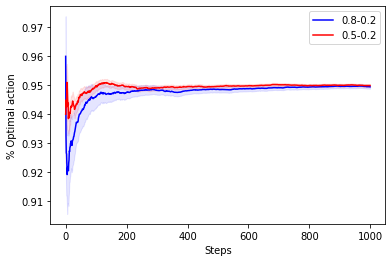

In [ ]:
som1 = np.std(perc_opt_act1,axis = 1) / np.sqrt(perc_opt_act1.shape[1])
mean1 = np.mean(perc_opt_act1,axis = 1)

som2 = np.std(perc_opt_act2,axis = 1) / np.sqrt(perc_opt_act2.shape[1])
mean2 = np.mean(perc_opt_act2,axis = 1)

fig, ax = plt.subplots()
ax.plot(range(1000), mean1, 'b')
ax.fill_between(range(1000), (mean1-som1), (mean1+som1), color='b', alpha=.1)
ax.plot(range(1000), mean2,'r')
ax.fill_between(range(1000), (mean2-som2), (mean2+som2), color='r', alpha=.1)
ax.set_ylabel('% Optimal action',rotation = 90)
ax.set_xlabel('Steps')
ax.legend(["0.8-0.2" , "0.5-0.2"])
plt.show()

# Social Learning

In [ ]:
class Sciety():
    def __init__(self, env=None, thompson_agent = 0, percent_agents = 1, p = [0.01], increase = [0.005], limit = [0.9], worst_agents = 1, random_agents = 4, UCBagent = 0):
        self.agents = []
        self.names = []
        self.thompson_agent, self.percent_agents , self.p , self.increase , self.limit, self.worst_agents , self.random_agents, self.env = thompson_agent , percent_agents , p , increase , limit , worst_agents , random_agents, env
        self.historyTotal = {}
        self.UCBagent = UCBagent
        for i in range(thompson_agent+percent_agents+worst_agents+random_agents +UCBagent):
            self.historyTotal[i] = []
        self.historyTotalR = {}
        for i in range(thompson_agent+percent_agents+worst_agents+random_agents +UCBagent):
            self.historyTotalR[i] = []
        
    def reset(self, env):
        self.env = env
        self.agents = []
        self.names = []
        for i in range(self.UCBagent):
            self.agents.append(UCB(environment = self.env,id = len(self.agents)))
        for i in range(self.thompson_agent):
            self.agents.append(ThompsonAgent(environment = self.env,id = len(self.agents)))
            self.names.append("thompson")
        for i in range(self.random_agents):
            self.agents.append(alwaysRandomAgent(self.env,len(self.agents)))
            self.names.append("random")
        for i in range(self.percent_agents):
            self.agents.append(percentBestAgent(self.env,0.1,[1,1,1,1],len(self.agents), self.p[i], self.increase[i],self.limit[i]))
            self.names.append("percent("+str(self.p[i])+","+str(self.increase[i])+","+str(self.limit[i])+")")
        for i in range(self.worst_agents):
            self.agents.append(alwaysWorstAgent(self.env,len(self.agents)))
            self.names.append("worst")
        self.history = {}
        for i in range(len(self.agents)):
            self.history[i] = []
        self.historyR = {}
        for i in range(len(self.agents)):
            self.historyR[i] = []
        
    def step(self):
        for a in range(len(self.agents)):
            obs, Ri, index_selected_arm = self.agents[a].take_action()
            self.history[a].append(index_selected_arm)
            self.historyR[a].append(Ri)
    def historyRecord(self):
        for a in range(len(self.agents)):
            self.historyTotal[a].append(self.history[a])
            self.historyTotalR[a].append(self.historyR[a])
        self.history = {}
        for i in range(len(self.agents)):
            self.history[i] = []
        self.historyR = {}
        for i in range(len(self.agents)):
            self.historyR[i] = []
    def getCategories(self):
        temp = {}
        index = []
        for n in range(len(self.names)):
            if self.names[n] not in temp.keys() or "percent" in self.names[n]:
                temp[self.names[n]] = 0
                index.append(n)
        return index

In [ ]:
class SocialLearning:
    def __init__(self, learner, society, individual, k_n_thr = 0, limit = 10000):
        self.learner = learner
        self.society = society
        self.individual = individual
        self.history = []
        self.historyR = []
        self.historyindividual = []
        self.historyindividualR = []
        self.best = []
        self.bestR = []
        self.preference_history = {}
        self.id = 0
        self.k_n_thr = k_n_thr
        self.limit = limit

    def iteration(self, env, trial_cnt, preferencelearner, threshold = 1000, noize = 0):
        self.society.reset(env)
        history = []
        historyR = []
        historyindividual = []
        historyindividualR = []
        if env.arm_count/len(self.society.agents) > self.k_n_thr:
            socialLearner = self.learner(env,0.1,len(self.society.agents), preferencelearner, noize, self.limit)
            self.id = socialLearner.id
        else:
            socialLearner = self.individual(environment = env,id = 0)
        for i in range(trial_cnt):
            self.society.step()
            obs, Ri, index_selected_arm = socialLearner.take_action()
            history.append(index_selected_arm)
            historyR.append(Ri)
        if env.arm_count/len(self.society.agents) > self.k_n_thr:
            for i in range(len(socialLearner.preference_history)):
                self.preference_history[i].append(socialLearner.preference_history[i])
        individualLearner = self.individual(environment = env,id = 0)
        for i in range(trial_cnt):
            obs, Ri, index_selected_arm = individualLearner.take_action()
            historyindividual.append(index_selected_arm)
            historyindividualR.append(Ri)
        self.historyindividual.append(historyindividual)
        self.historyindividualR.append(historyindividualR)
        self.society.historyRecord()
        self.history.append(history)
        self.historyR.append(historyR)
    def loop(self, epoch = 10, iteration = 10, vars = [], rewards = [(i-100)/10 for i in range(200)], threshold = 1000, noize = 0, n = [100], reward_var = None, reward_means = None, random_reward = True, k = None, preferencelearner = None):
        for i in range(len(self.society.historyTotal.keys())+1):
            self.preference_history[i] = []
        for (reward_means,reward_var) in zip(rewards, vars):
            for i in range(iteration):               
                env = NArmedBanditEnvironment(len(reward_means), reward_means, reward_var)
                self.iteration(env, 1000, preferencelearner)
                self.best.append(np.argmax(reward_means))
                self.bestR.append(np.max(reward_means))
    def optimalaction(self, hist):
        poa = []
        for i in range(len(hist)):
            temp = [0]
            for index_selected_arm in hist[i]:
                temp.append(temp[-1]+int(index_selected_arm==self.best[i]))
            temp = temp[1:]
            for t in range(len(temp)):
                temp[t] = temp[t]/(t+1)
            poa.append(temp)
        return poa
    def regret(self, hist):
        poa = []
        for i in range(len(hist)):
            temp = [((j+1)*self.bestR[i]-np.sum(hist[i][0:j])) for j in range(len(hist[i]))]
            poa.append(temp)
        return poa
    def creward(self, hist):
        poa = []
        for i in range(len(hist)):
            poa.append(hist[i])
        return poa
    def regretc(self, hist):
        poa = []
        for i in range(len(hist)):
            temp = [(self.bestR[i]-hist[i][j]) for j in range(len(hist[i]))]
            poa.append(temp)
        return poa
    def compare(self, all = False):
        if all:
            index = [i for i in range(len(self.society.agents))]
        else:
            index = self.society.getCategories()
        data = {}
        data["history action"] = self.history
        data["history reward"] = self.historyR
        data["index"] = index
        data["history individual action"] = self.historyindividual
        data["history individual reward"] = self.historyindividualR
        data["optimal action"] = self.best
        data["optimal action reward"] = self.bestR
        tmp = {}
        tmp["social"] = self.preference_history[self.id]
        for i in index:
            tmp[self.society.names[i]] = self.preference_history[i]
        data["preference"] = tmp
        poa = {}
        poa["social"] = self.optimalaction(self.history)
        poa["individual"] = self.optimalaction(self.historyindividual)
        for i in index:
            poa[self.society.names[i]] = self.optimalaction(self.society.historyTotal[i])
        data["percent of selecting the optimal action"] = poa
        poa = {}
        poa["social"] = self.regret(self.historyR)
        poa["individual"] = self.regret(self.historyindividualR)
        data["regret"] = poa
        poa = {}
        poa["social"] = self.regretc(self.historyR)
        poa["individual"] = self.regretc(self.historyindividualR)
        data["regretc"] = poa
        poa = {}
        poa["social"] = self.creward(self.historyR)
        poa["individual"] = self.creward(self.historyindividualR)
        data["creward"] = poa
        return data